<a href="https://colab.research.google.com/github/Ayush9719/Fellowship-Ai/blob/main/Sentiment%20Analysis%20on%20Amazon%20Reviews%20using%20ULMFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tqdm import tqdm_notebook
import torch
import fastai
from fastai.text import *
fastai.__version__

'1.0.61'

In [3]:
path = untar_data(URLs.AMAZON_REVIEWS, dest = "Data")

In [4]:
path.ls()

[PosixPath('Data/amazon_review_full_csv/lm_databunch-amazon'),
 PosixPath('Data/amazon_review_full_csv/models'),
 PosixPath('Data/amazon_review_full_csv/test.csv'),
 PosixPath('Data/amazon_review_full_csv/readme.txt'),
 PosixPath('Data/amazon_review_full_csv/train.csv')]

In [5]:
train_df = pd.read_csv(path/'train.csv', header=None, names=['Rating', 'Title', 'Review'], skiprows=(2000000))
train_df.head()

,Rating,Title,Review
0,3,Interesting form.,Interesting kung fu style-- Combination of Whi...
1,4,Excellent advice on cutting fat & increasing f...,This is a well organized book with lots of use...
2,5,"Wise, practical, and medically sound",Life is about making choices and owning up to ...
3,1,Starve your kids now so they can be fat later.,Another book that teaches kids that being bigg...
4,3,If John Sayles adapted a Joseph Wambaugh story...,Evenhand is a very impressive accomplishment: ...


In [6]:
valid_df = pd.read_csv(path/'test.csv', header=None, names=['Rating', 'Title', 'Review'], skiprows=(435000))
valid_df.head()

,Rating,Title,Review
0,3,product quality good but ivory color not,I ordered the ivory color of these plates as I...
1,5,made in america,I currently own six of these sets in different...
2,2,Fiesta Dishes,I have several place settings of Fiesta Dishes...
3,2,Place setting,I read the title wrong. I thought I was gettin...
4,5,Excellent reference,This book is for any mother in the process of ...


**The Language Model Data Object**

In [7]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df[:1000], valid_df=valid_df[:1000], text_cols=2, label_cols=0)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [8]:
data_lm.save('lm_databunch-amazon')

**Training the Language Mode**

In [9]:
learn = language_model_learner(data_lm, drop_mult=0.3, arch=AWD_LSTM)

**Finding a Learning Rate**

In [10]:
learn.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.58E-01
Min loss divided by 10: 2.51E-02


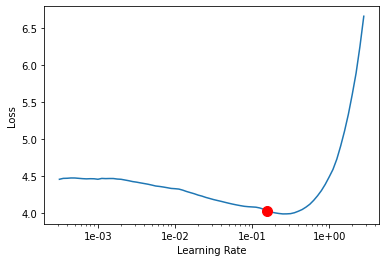

In [11]:
learn.recorder.plot(skip_end=10, suggestion=True)

In [12]:
best_lm_lr = 1E-02

**Training**

In [13]:
%%time
learn.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.289950,3.798102,0.282175,02:36


CPU times: user 2min 36s, sys: 1.01 s, total: 2min 37s
Wall time: 2min 36s


In [14]:
learn.save('lm-fit_1')

In [15]:
learn.load('lm-fit_1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (1000 items)
x: LMTextList
xxbos xxmaj interesting kung fu xxunk xxmaj combination of xxmaj white xxmaj xxunk and xxmaj xxunk xxmaj xxunk ? xxmaj the practitioners seem to have solid xxunk and not a lot of superfluous or wasted movement . xxmaj would like to have seen more applications xxunk just a couple in the last few minutes of the video , basically an arm lock and a push . xxmaj thanks to xxmaj amazon for making these available to rent ! xxmaj enjoyable for esoteric xxunk arts video junkies like myself , gives you a chance to see what other styles you 're not likely to find at the local xxunk xxunk are doing , and to " try before you buy " . i 've bought several videos from the same company as this one on sale cheap , some are excellent , some are lousy , this one is in the middle . xxmaj not recommended for people wanting to learn self defense because a ) self defense applications are not xxunk out clearly , and b ) even if 

In [16]:
learn.unfreeze()

In [17]:
%%time
learn.fit_one_cycle(5, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.881527,3.736381,0.279177,03:49
1,3.581519,3.864694,0.268527,03:48
2,3.084628,4.035291,0.255091,03:49
3,2.456693,4.376310,0.238956,03:48
4,1.902664,4.491127,0.239520,03:48


CPU times: user 18min 57s, sys: 12.3 s, total: 19min 9s
Wall time: 19min 4s


In [18]:
learn.save('lm-fine_tuned')

In [19]:
learn.save_encoder('lm-fine_tuned_enc')

**Building a Classifier**

In [20]:
data_clas = TextClasDataBunch.from_df(path, train_df=train_df[:1000], valid_df=valid_df[:1000], text_cols=2, label_cols=0, vocab=data_lm.train_ds.vocab)

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [21]:
data_clas.save('class-databunch-amazon')

In [22]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=1)

In [23]:
learn_c.load_encoder('lm-fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1000 items)
x: TextList
xxbos xxmaj interesting kung fu xxunk xxmaj combination of xxmaj white xxmaj xxunk and xxmaj xxunk xxmaj xxunk ? xxmaj the practitioners seem to have solid xxunk and not a lot of superfluous or wasted movement . xxmaj would like to have seen more applications xxunk just a couple in the last few minutes of the video , basically an arm lock and a push . xxmaj thanks to xxmaj amazon for making these available to rent ! xxmaj enjoyable for esoteric xxunk arts video junkies like myself , gives you a chance to see what other styles you 're not likely to find at the local xxunk xxunk are doing , and to " try before you buy " . i 've bought several videos from the same company as this one on sale cheap , some are excellent , some are lousy , this one is in the middle . xxmaj not recommended for people wanting to learn self defense because a ) self defense applications are not xxunk out clearly , and b ) even if they 

**Training the Sentiment Classifier**

In [24]:
learn_c.lr_find()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-03
Min loss divided by 10: 3.02E-02


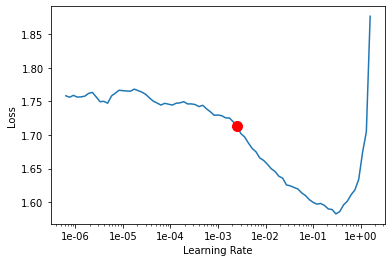

In [26]:
learn_c.recorder.plot(suggestion=True)

In [27]:
learn_c.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.585029,1.506671,0.319000,02:02
1,1.475064,1.502566,0.342000,01:56


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [28]:
learn_c.save('class-first')

In [29]:
learn_c.load('class-first')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1000 items)
x: TextList
xxbos xxmaj interesting kung fu xxunk xxmaj combination of xxmaj white xxmaj xxunk and xxmaj xxunk xxmaj xxunk ? xxmaj the practitioners seem to have solid xxunk and not a lot of superfluous or wasted movement . xxmaj would like to have seen more applications xxunk just a couple in the last few minutes of the video , basically an arm lock and a push . xxmaj thanks to xxmaj amazon for making these available to rent ! xxmaj enjoyable for esoteric xxunk arts video junkies like myself , gives you a chance to see what other styles you 're not likely to find at the local xxunk xxunk are doing , and to " try before you buy " . i 've bought several videos from the same company as this one on sale cheap , some are excellent , some are lousy , this one is in the middle . xxmaj not recommended for people wanting to learn self defense because a ) self defense applications are not xxunk out clearly , and b ) even if they 

In [32]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.423040,1.484008,0.329000,02:08


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [33]:
learn_c.save('class-2nd')

In [34]:
learn_c.load('class-2nd');

In [35]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.378896,1.460778,0.358000,03:15


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [36]:
learn_c.save('class-3rd')

In [37]:
learn_c.load('class-3rd')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (1000 items)
x: TextList
xxbos xxmaj interesting kung fu xxunk xxmaj combination of xxmaj white xxmaj xxunk and xxmaj xxunk xxmaj xxunk ? xxmaj the practitioners seem to have solid xxunk and not a lot of superfluous or wasted movement . xxmaj would like to have seen more applications xxunk just a couple in the last few minutes of the video , basically an arm lock and a push . xxmaj thanks to xxmaj amazon for making these available to rent ! xxmaj enjoyable for esoteric xxunk arts video junkies like myself , gives you a chance to see what other styles you 're not likely to find at the local xxunk xxunk are doing , and to " try before you buy " . i 've bought several videos from the same company as this one on sale cheap , some are excellent , some are lousy , this one is in the middle . xxmaj not recommended for people wanting to learn self defense because a ) self defense applications are not xxunk out clearly , and b ) even if they 

In [38]:
learn_c.unfreeze()
learn_c.fit_one_cycle(5, slice(1e-3/(2.6**4), 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.308628,1.450467,0.357000,04:10
1,1.307903,1.436624,0.369000,04:17
2,1.279905,1.430527,0.373000,03:56
3,1.272667,1.431498,0.371000,04:07
4,1.267079,1.420936,0.369000,04:13


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [39]:
learn_c.save('classification')

In [40]:
learn_c.predict("I really loved that shirt, it fit perfectly.")

(Category tensor(4),
 tensor(4),
 tensor([0.0024, 0.0142, 0.0241, 0.0897, 0.8696]))

In [41]:
learn_c.predict("I didn't really like the table, it was ugly.")

(Category tensor(1),
 tensor(1),
 tensor([0.1804, 0.4248, 0.2756, 0.0516, 0.0675]))